In [97]:
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import seaborn as sns


In [98]:
res_dir = 'res'
experiments = ['mrcv_mites','mrcv_all','sun_all','sun_mites']
#experiments = ['sun_all','sun_mites']
#res_dir = 'all_res'
path = '/home/juan/Desktop/juan/bio/mirna_mite/data/shortstack/%s/Results.txt'
path_annotation = '/home/juan/Desktop/juan/bio/mirna_mite/data/introns.gff3'
path_annotation_promoters = '/home/juan/Desktop/juan/bio/mirna_mite/data/promoters.gff3'
path_mites = "/home/juan/Desktop/juan/bio/mirna_mite/data/mites_consensus.fasta"
path_mites_res = '/home/juan/Desktop/juan/bio/mirna_mite/data/' + res_dir + '/mites_prod.fasta'
path_res = '/home/juan/Desktop/juan/bio/mirna_mite/data/' + res_dir + '/all_results.csv'
path_mirna_seq = '/home/juan/Desktop/juan/bio/mirna_mite/data/' + res_dir + '/mirna.y.fasta'
path_mirna_seq_trep = '/home/juan/Desktop/juan/bio/mirna_mite/data/' + res_dir + '/mirna.y.trep.fasta'
path_mirna_mites_seq = '/home/juan/Desktop/juan/bio/mirna_mite/data/' + res_dir + '/mirna.mites.y.fasta'
path_mirna_mature = '/home/juan/Desktop/juan/bio/mirna_mite/data/' + res_dir + '/mirna.y.mature.csv'
path_res_seq = '/home/juan/Desktop/juan/bio/mirna_mite/data/' + res_dir + '/all_results.fasta'
path_genome = '/home/juan/Desktop/juan/bio/data/IWGSC/42/Triticum_aestivum.IWGSC.dna.toplevel.fa'
path_blast_res = '/home/juan/Desktop/juan/bio/mirna_mite/data/' + res_dir + '/blast_mites.csv'
path_mirbase = '/home/juan/Desktop/juan/bio/mirna_mite/data/mature.fa'

In [99]:
### Load shortstack results
dfs = {}
for experiment in experiments:
    experiment_path = path % (experiment,)
    df = pd.read_csv(experiment_path, sep='\t')
    df['Name'] = experiment + '_' + df['Name']
    print('Experiment:', experiment)
    print('All results:',len(df.index))
    #df = df[df.MIRNA == 'Y']
    #print('Only miRNAs:',len(df.index))
    df = df[df.Reads > 15]
    print('Only miRNAs +20 reads:',len(df.index))
    df = df[df['21'] > 10]
    print('Only miRNAs 21nt +5 reads:',len(df.index))
    print('*' * 10)
    dfs[experiment] = df

Experiment: mrcv_mites
All results: 1211339
Only miRNAs +20 reads: 27597
Only miRNAs 21nt +5 reads: 1751
**********
Experiment: mrcv_all
All results: 38532
Only miRNAs +20 reads: 38532
Only miRNAs 21nt +5 reads: 10778
**********
Experiment: sun_all
All results: 157492
Only miRNAs +20 reads: 157492
Only miRNAs 21nt +5 reads: 44964
**********
Experiment: sun_mites
All results: 1211339
Only miRNAs +20 reads: 62212
Only miRNAs 21nt +5 reads: 3609
**********


In [100]:
dfs = [ v for v in dfs.values() ]

In [101]:
df = pd.concat(dfs)

In [102]:
len(df.index)

61102

In [103]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,DicerCall,MIRNA,PhaseScore,Short,Long,20,21,22,23,24
669,1A:7191963-7192334,mrcv_mites_MITE_T_7077|chr2B|403696383|4036967...,372,65,0.510,4,0.031,-,UUUUUUGUCGAGAGUUGCUCA,36,...,21,N15,-1.0,4,0,13,38,0,0,10
777,1A:8267612-8267880,mrcv_mites_MITE_T_22970|chr5A|493341243|493341...,269,122,0.957,9,0.361,.,AGUUUGACUUCGGAGAAUUCUAAU,25,...,24,N6,0.2,0,5,0,25,2,5,85


In [104]:
#rename correctly all loci

In [105]:
df['Name'] = df['Name'].str.split('|').str[0]

In [106]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,DicerCall,MIRNA,PhaseScore,Short,Long,20,21,22,23,24
669,1A:7191963-7192334,mrcv_mites_MITE_T_7077,372,65,0.510,4,0.031,-,UUUUUUGUCGAGAGUUGCUCA,36,...,21,N15,-1.0,4,0,13,38,0,0,10
777,1A:8267612-8267880,mrcv_mites_MITE_T_22970,269,122,0.957,9,0.361,.,AGUUUGACUUCGGAGAAUUCUAAU,25,...,24,N6,0.2,0,5,0,25,2,5,85


In [107]:
df['seqname'] = df['#Locus'].str.split(':').str[0]
df['position'] = df['#Locus'].str.split(':').str[1]
df['start'] = df.position.str.split('-').str[0].astype(int)
df['end'] = df.position.str.split('-').str[1].astype(int)

In [108]:
df['Name'] = df['Name'] + '_' + df['seqname'] + '_' + df['start'].astype(str) + '_' + df['end'].astype(str)

In [109]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Long,20,21,22,23,24,seqname,position,start,end
669,1A:7191963-7192334,mrcv_mites_MITE_T_7077_1A_7191963_7192334,372,65,0.510,4,0.031,-,UUUUUUGUCGAGAGUUGCUCA,36,...,0,13,38,0,0,10,1A,7191963-7192334,7191963,7192334
777,1A:8267612-8267880,mrcv_mites_MITE_T_22970_1A_8267612_8267880,269,122,0.957,9,0.361,.,AGUUUGACUUCGGAGAAUUCUAAU,25,...,5,0,25,2,5,85,1A,8267612-8267880,8267612,8267880


In [110]:
df[df.duplicated(['Name'],keep=False)]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Long,20,21,22,23,24,seqname,position,start,end


In [111]:
df = df.reset_index(drop=True)


In [112]:
print(len(df.index))

61102


In [113]:
df[df.index.isin(['876749','876750','876751','27433'])]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Long,20,21,22,23,24,seqname,position,start,end
27433,3B:262192194-262193584,sun_all_Cluster_55362_3B_262192194_262193584,1391,457,3.619,302,0.341,.,UGGAAAAAUAUAGGAUGGCCGAAU,16,...,4,18,25,25,46,317,3B,262192194-262193584,262192194,262193584


In [114]:
df_sep = {}
for seqname in df.seqname.unique():
    df_sep[seqname] = df[df.seqname == seqname]


In [115]:
min_distance = 150
duplicated = []
for k,v in df.iterrows():
    if k in duplicated:
        continue
    other = df_sep[v.seqname]
    other = other[(other.index != k) & 
                (other.MajorRNA == v.MajorRNA) &
                (abs(other.start - v.start) <= min_distance) & 
                (abs(other.end - v.end) <= min_distance)]
    if len(other.index) > 0:
        duplicated += other.index.tolist()

In [116]:
duplicated = set(duplicated)
print(len(duplicated))

2817


In [117]:
print(len(df.index))

61102


In [118]:
df = df[~df.index.isin(duplicated)]
count_total = len(df.index)
count_total

58285

In [119]:
df.MIRNA.value_counts()

N6     27678
N11    10103
N2      8271
N5      7778
N14     1137
N12      986
N13      968
N15      862
Y        247
N4       229
N8        26
Name: MIRNA, dtype: int64

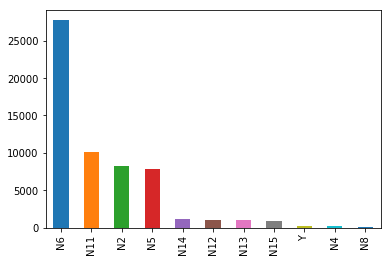

In [120]:
df.MIRNA.value_counts().plot('bar')

In [121]:
df = df[df.MIRNA == 'Y']
print('Only miRNAs:',len(df.index))

Only miRNAs: 247


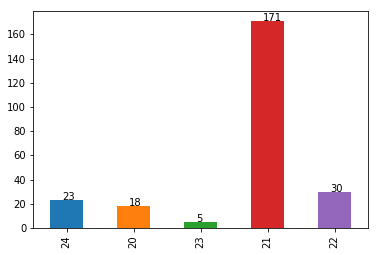

In [122]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot
ax = df.DicerCall.value_counts(sort=False).plot('bar')
x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
pyplot.savefig('../data/res/mirna_sizes.png',transparent=True, bbox_inches='tight', pad_inches=0)

In [31]:
df.head(3)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Long,20,21,22,23,24,seqname,position,start,end
125,1D:147896240-147896319,mrcv_mites_MITE_T_120271_1D_147896240_147896319,80,45,0.353,1,1.000,+,UAUAUUUUGGUACGGAGGGAU,22,...,4,2,38,1,0,0,1D,147896240-147896319,147896240,147896319
223,2A:168984136-168984233,mrcv_mites_MITE_T_102616_2A_168984136_168984233,98,198,1.554,2,0.045,-,UCGGAAUUAGUUGACACUCAAA,86,...,1,1,39,89,63,1,2A,168984136-168984233,168984136,168984233
510,3A:19302861-19302943,mrcv_mites_MITE_T_105526_3A_19302861_19302943,83,108,0.848,10,0.972,+,UCCAAUUACUCGUCGUGGUUU,89,...,2,0,99,4,0,3,3A,19302861-19302943,19302861,19302943


In [32]:
df_mites = df[df.Name.str.contains('MITE')]
count_mites = len(df_mites.index)
count_mites

18

In [33]:
df_nomites = df[~df.Name.str.contains('MITE')]
count_nomites = len(df_nomites.index)
count_nomites

229

In [34]:
count_mites * 100 / count_total

0.030882731406022133

In [35]:
#get sequences
df.sort_values(['seqname', 'start'], inplace=True)


In [36]:
fasta_seq = SeqIO.parse(path_genome, 'fasta')
   

In [37]:
buffer_seqs = []

for record in fasta_seq:
    dff_extract = df[df.seqname == record.id]
    print(record.id, len(dff_extract.index))
    clean_seq = ''.join(str(record.seq).splitlines())
    for k,v in dff_extract.iterrows():
        start = min(v.start,v.end)
        end = max(v.start,v.end)
        new_seq = clean_seq[start:end]
        id = v.Name
        desc = record.id + "_" + str(start) + '_' + str(end)
        seq = SeqRecord(Seq(new_seq), id=id, description=desc)
        buffer_seqs.append(seq)
SeqIO.write(buffer_seqs, path_res_seq, "fasta")
print(path_res_seq)

1A 4
1B 6
1D 6
2A 13
2B 17
2D 5
3A 9
3B 8
3D 11
4A 15
4B 7
4D 9
5A 18
5B 13
5D 20
6A 18
6B 15
6D 15
7A 14
7B 17
7D 5
Un 2
/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.fasta


In [38]:
path_res_seq

'/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.fasta'

In [39]:
cmd = "blastn -evalue 1e-3 -task blastn -subject data/%s/all_results.fasta -query  data/mites_consensus.fasta -outfmt '6 qseqid sseqid qstart qend sstart send mismatch gaps pident evalue length qlen slen qcovs score'  > data/%s/blast_mites.csv"
cmd = cmd % (res_dir,res_dir)
cmd

"blastn -evalue 1e-3 -task blastn -subject data/res/all_results.fasta -query  data/mites_consensus.fasta -outfmt '6 qseqid sseqid qstart qend sstart send mismatch gaps pident evalue length qlen slen qcovs score'  > data/res/blast_mites.csv"

In [40]:
df_ = df

In [41]:
df_trep = pd.read_csv(path_blast_res, sep="\t")
cols = ['qseqid','sseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_trep.columns = cols
df_trep = df_trep[df_trep.pident >= 80]
df_trep = df_trep[(df_trep.length / df_trep.slen) >= 0.8]
#df_trep = df_trep[df_trep.qcovs >= 80]
print(len(df_trep.index))
df_trep.head(2)

271


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,MITE_0,mrcv_mites_MITE_T_121053_3D_508204974_508205052,3,79,78,1,12,1,83.333,4.990000e-18,78,80,78,98,86
15,MITE_5,mrcv_mites_MITE_T_58879_6D_361524524_361524682,2,157,158,2,13,3,89.873,3.750000e-55,158,157,158,100,224


In [42]:
df_trep.qseqid.nunique()

143

In [43]:
df_trep.sseqid.nunique()

25

In [44]:
#get the best MITE for each cluster

In [45]:
df_trep = df_trep[['qseqid','sseqid','score']]
df_trep.rename(columns={'qseqid':'MITE','sseqid':'cluster'}, inplace=True)

In [46]:
for cluster in list(df_trep.cluster.unique()):
    other = df_trep[df_trep.cluster == cluster]
    dtt = other[other.MITE.str.contains('DTT')]
    if len(dtt.index) > 0:
        df.loc[df.Name == cluster, 'MITE'] = dtt.loc[dtt['score'].idxmax()].MITE
    else:
        tracker = other[other.MITE.str.contains('MITE_')]
        if len(tracker.index) > 0:
            df.loc[df.Name == cluster, 'MITE'] = tracker.loc[tracker['score'].idxmax()].MITE


In [47]:
#df.drop("qseqid", axis=1, inplace=True)

In [48]:
total_count = len(df.index)
total_count

247

In [49]:
df_new_not_mites = df[df.MITE.isnull()]
count_not_mites = len(df_new_not_mites.index)
count_not_mites

222

In [50]:
df_new_mites = df[df.MITE.notnull()]
count_mites = len(df_new_mites.index)
count_mites

25

In [51]:
count_mites * 100 / total_count

10.121457489878543

In [52]:
#mirbase

In [53]:
buffer_seqs = []
alls = {}
for k,v in df.iterrows():
    if v.Name in alls:
        print(v.Name)
    alls[v.Name] = 1
    desc = v['#Locus']
    seq = SeqRecord(Seq(v.MajorRNA), id=v.Name, description="")
    buffer_seqs.append(seq)
SeqIO.write(buffer_seqs, path_mirna_seq, "fasta")
print(len(buffer_seqs))
print(path_mirna_seq)

247
/home/juan/Desktop/juan/bio/mirna_mite/data/res/mirna.y.fasta


In [54]:
buffer_seqs = []
for k,v in df[df.MITE.notnull()].iterrows():
    id = v.Name
    desc = v['#Locus']
    if "|" in id:
        id = id.split("|")[0]
    seq = SeqRecord(Seq(v.MajorRNA), id=id, description="")
    buffer_seqs.append(seq)
SeqIO.write(buffer_seqs, path_mirna_seq_trep, "fasta")
print(len(buffer_seqs))
print(path_mirna_seq_trep)

25
/home/juan/Desktop/juan/bio/mirna_mite/data/res/mirna.y.trep.fasta


In [61]:
df_mirbase = pd.read_csv(path_mirna_mature, sep="\t")
cols = ['qseqid','sseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_mirbase.columns = cols
print(len(df_mirbase.index))
df_mirbase.head(2)

16821


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,mrcv_all_Cluster_1015_1A_419025472_419025570,tca-miR-6017-5p,5,15,10,20,0,0,100.0,1.30,11,22,20,50,22
1,mrcv_all_Cluster_1205_1A_492271825_492271935,tgu-miR-1669,1,12,20,9,0,0,100.0,0.38,12,22,20,55,24


In [62]:
allowed_mirbase_mismatches = 7
mirbase_qlen = 7

In [63]:
df_mirbase = df_mirbase[df_mirbase.length > df_mirbase.qlen - mirbase_qlen]
print(len(df_mirbase.index))


15554


In [64]:
df_mirbase = df_mirbase[df_mirbase.mismatch + df_mirbase.gaps <= allowed_mirbase_mismatches]
print(len(df_mirbase.index))


15554


In [65]:
len(df_mirbase.qseqid.unique().tolist())


154

In [66]:
df_mirbase.head(2)

,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
13,sun_all_Cluster_8835_1B_161992200_161992280,hvu-miR6197,1,21,1,21,2,0,90.476,0.002000,21,21,21,100,32
19,mrcv_all_Cluster_2061_1B_357916189_357916332,aof-miR166d,1,21,1,21,0,0,100.000,0.000004,21,21,21,100,42


In [67]:
df_mirbase = df_mirbase.loc[df_mirbase.groupby("qseqid")["score"].idxmax()]
df_mirbase = df_mirbase[['qseqid','sseqid']]
df_mirbase.rename(columns={'sseqid':'mirbase'}, inplace=True)


In [68]:
print(len(df_mirbase.index))
df_mirbase.head(2)


154


,qseqid,mirbase
3050,mrcv_all_Cluster_10098_2D_428672116_428672312,eun-miR530-5p
3093,mrcv_all_Cluster_10582_2D_568229232_568229332,tae-miR9776


In [69]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,20,21,22,23,24,seqname,position,start,end,MITE
2040,1A:309399489-309399664,mrcv_all_Cluster_872_1A_309399489_309399664,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,35,440,61,5,4,1A,309399489-309399664,309399489,309399664,NaN
2078,1A:419025472-419025570,mrcv_all_Cluster_1015_1A_419025472_419025570,99,384,3.014,20,1.000,+,CGAAUGUAUUUUUUAUGGCUUG,249,...,27,83,264,3,2,1A,419025472-419025570,419025472,419025570,NaN


In [70]:
df = pd.merge(df, df_mirbase, how='left', left_on='Name', right_on='qseqid')

In [71]:
df.head(2)


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,qseqid,mirbase
0,1A:309399489-309399664,mrcv_all_Cluster_872_1A_309399489_309399664,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,61,5,4,1A,309399489-309399664,309399489,309399664,NaN,NaN,NaN
1,1A:419025472-419025570,mrcv_all_Cluster_1015_1A_419025472_419025570,99,384,3.014,20,1.000,+,CGAAUGUAUUUUUUAUGGCUUG,249,...,264,3,2,1A,419025472-419025570,419025472,419025570,NaN,NaN,NaN


In [72]:
df.drop("qseqid", axis=1, inplace=True)

In [73]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,seqname,position,start,end,MITE,mirbase
0,1A:309399489-309399664,mrcv_all_Cluster_872_1A_309399489_309399664,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,440,61,5,4,1A,309399489-309399664,309399489,309399664,NaN,NaN
1,1A:419025472-419025570,mrcv_all_Cluster_1015_1A_419025472_419025570,99,384,3.014,20,1.000,+,CGAAUGUAUUUUUUAUGGCUUG,249,...,83,264,3,2,1A,419025472-419025570,419025472,419025570,NaN,NaN


In [74]:
len(df.index)

247

In [75]:
#genomic annotation

In [76]:
df_ann = pd.read_csv(path_annotation, index_col=False, sep='\t', comment='#', header=None)
df_ann.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']


In [77]:
print(len(df_ann.index))


2573211


In [78]:
df_ann = df_ann[
    (df_ann.feature == 'intron') | 
    (df_ann.feature == 'exon') | 
    (df_ann.feature == 'three_prime_UTR') | 
    (df_ann.feature == 'five_prime_UTR')]
print(len(df_ann.index))


1593666


In [79]:
df_ann_promoters = pd.read_csv(path_annotation_promoters, index_col=False, sep='\t', comment='#', header=None)
df_ann_promoters.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']
print(len(df_ann_promoters.index))


120744


In [80]:
df_ann_total = pd.concat([df_ann, df_ann_promoters])


In [81]:
df_ann_total.head(2)

,seqname,source,feature,start,end,score,strand,frame,attribute
2,1A,Ensembl_Plants,exon,200,1683,.,+,.,Parent=transcript:ENSRNA050013875-T1;Name=ENSR...
5,1A,Ensembl_Plants,exon,5023,6833,.,+,.,Parent=transcript:ENSRNA050013847-T1;Name=ENSR...


In [82]:
len(df_ann_total.index)


1714410

In [83]:
df_anns = {}
for chromosome in df_ann_total.seqname.unique():
    df_anns[chromosome] = df_ann_total[df_ann_total.seqname == chromosome]


In [84]:
df.head(1)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,seqname,position,start,end,MITE,mirbase
0,1A:309399489-309399664,mrcv_all_Cluster_872_1A_309399489_309399664,176,553,4.34,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,440,61,5,4,1A,309399489-309399664,309399489,309399664,NaN,NaN


In [85]:
df['annotation'] = 'intergenic'

In [86]:
for k,v in df.iterrows():
    other = df_anns[v.seqname]
    other = other[(other.end >= v.start) & (other.start <= v.end)]
    if len(other.index) > 0:
        features = set(other.feature.tolist())
        str_features = ', '.join(features)
        if df.loc[k, 'annotation'] == 'three_prime_UTR' or df.loc[k, 'annotation'] == 'five_prime_UTR':
            continue
        df.loc[k, 'annotation'] = str_features

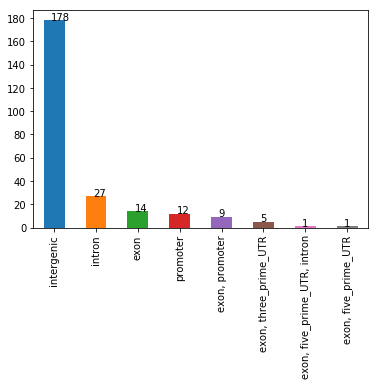

In [87]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot
ax = df.annotation.value_counts().plot('bar')
x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
pyplot.savefig('../data/res/mirna_all.png',transparent=True, bbox_inches='tight', pad_inches=0)

In [88]:
#let's have some fun with data

In [89]:
df[df.MITE.notnull()].annotation.value_counts()

intron                   12
intergenic               10
promoter                  2
exon, three_prime_UTR     1
Name: annotation, dtype: int64

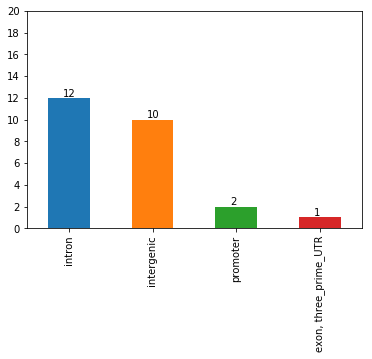

In [90]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot
ax = df[df.MITE.notnull()].annotation.value_counts().plot('bar')
x_offset = -0.07
y_offset = 0.15
ax.set_ylim(0,20)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
pyplot.savefig('../data/res/mirna_mite.png',transparent=True, bbox_inches='tight', pad_inches=0)

In [91]:
len(df.index)

247

In [92]:
print(len(df[df.MITE.notnull()].index))
df[df.MITE.notnull()]

25


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,mirbase,annotation
4,1B:161992200-161992280,sun_all_Cluster_8835_1B_161992200_161992280,81,135,1.069,5,0.919,+,UCUGUUCACAAAUGUAAGACG,106,...,0,0,2,1B,161992200-161992280,161992200,161992280,MITE_1712,hvu-miR6197,intron
10,1D:147896240-147896319,mrcv_mites_MITE_T_120271_1D_147896240_147896319,80,45,0.353,1,1.000,+,UAUAUUUUGGUACGGAGGGAU,22,...,1,0,0,1D,147896240-147896319,147896240,147896319,MITE_1717,NaN,intron
16,2A:133702671-133702770,sun_mites_MITE_T_99232_2A_133702671_133702770,100,2289,18.126,2181,0.983,+,UGAGACGGGUAAUUUGGAACGGAG,1484,...,53,101,2001,2A,133702671-133702770,133702671,133702770,DTT_Tmon_Icarus_BG607724-1,NaN,promoter
19,2A:168984136-168984233,mrcv_mites_MITE_T_102616_2A_168984136_168984233,98,198,1.554,2,0.045,-,UCGGAAUUAGUUGACACUCAAA,86,...,89,63,1,2A,168984136-168984233,168984136,168984233,MITE_253,NaN,intron
29,2B:5671327-5671460,sun_all_Cluster_28681_2B_5671327_5671460,134,562,4.450,504,0.016,-,UAUCUGGACAAAUCUGAGACA,293,...,5,2,4,2B,5671327-5671460,5671327,5671460,DTT_Hvul_Pan_M801L24-1,NaN,intron
36,2B:482720682-482720772,sun_all_Cluster_33132_2B_482720682_482720772,91,102,0.808,91,0.078,-,AUCUUCUAUCGUGGGACGAAG,48,...,1,1,1,2B,482720682-482720772,482720682,482720772,DTT_Taes_Athos_BJ320318-1,NaN,intron
51,3A:19302861-19302943,mrcv_mites_MITE_T_105526_3A_19302861_19302943,83,108,0.848,10,0.972,+,UCCAAUUACUCGUCGUGGUUU,89,...,4,0,3,3A,19302861-19302943,19302861,19302943,DTT_Bdis_BdisStowawayT_consensus-1,tae-miR5175-5p,intron
63,3B:253488744-253488823,mrcv_mites_MITE_T_120628_3B_253488744_253488823,80,1099,8.625,21,0.002,-,AUAUUAUGUGACAGAAGGAGU,715,...,10,0,4,3B,253488744-253488823,253488744,253488823,DTT_Taes_Athos_BJ275764-1,NaN,intron
66,3B:587564305-587564383,mrcv_all_Cluster_13743_3B_587564305_587564383,79,76,0.596,68,1.000,+,AUUGUGUACAGAGGGAGUAGU,67,...,1,0,0,3B,587564305-587564383,587564305,587564383,MITE_867,NaN,intron
74,3D:472405006-472405092,mrcv_mites_MITE_T_110611_3D_472405006_472405092,87,387,3.037,64,0.114,-,ACACUUAUUUCCGAUCGGAGGG,223,...,228,0,30,3D,472405006-472405092,472405006,472405092,MITE_297,NaN,intron


In [93]:
#list(df[df.MITE.notnull()].MITE.unique())

In [94]:
df[(df.MITE.notnull()) & (df.mirbase.notnull())]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,mirbase,annotation
4,1B:161992200-161992280,sun_all_Cluster_8835_1B_161992200_161992280,81,135,1.069,5,0.919,+,UCUGUUCACAAAUGUAAGACG,106,...,0,0,2,1B,161992200-161992280,161992200,161992280,MITE_1712,hvu-miR6197,intron
51,3A:19302861-19302943,mrcv_mites_MITE_T_105526_3A_19302861_19302943,83,108,0.848,10,0.972,+,UCCAAUUACUCGUCGUGGUUU,89,...,4,0,3,3A,19302861-19302943,19302861,19302943,DTT_Bdis_BdisStowawayT_consensus-1,tae-miR5175-5p,intron
117,5A:552632192-552632284,mrcv_mites_MITE_T_95924_5A_552632192_552632284,93,46,0.361,0,0.000,-,UGCGGCACUUAUUUUGGGACG,40,...,0,0,0,5A,552632192-552632284,552632192,552632284,DTT_Bdis_BdisStowawayF_consensus-1,hvu-miR5049c,intergenic
224,7B:34679825-34679952,mrcv_mites_MITE_T_80536_7B_34679825_34679952,128,184,1.444,26,0.989,+,UGUCGUAGAUUUGUCUAGAUA,99,...,0,1,14,7B,34679825-34679952,34679825,34679952,DTT_Taes_Pan_42j2-6,hvu-miR6191,intergenic


In [95]:
df[df.MITE.notnull()][['#Locus','Name','MajorRNA','MITE','annotation','mirbase']]

,#Locus,Name,MajorRNA,MITE,annotation,mirbase
4,1B:161992200-161992280,sun_all_Cluster_8835_1B_161992200_161992280,UCUGUUCACAAAUGUAAGACG,MITE_1712,intron,hvu-miR6197
10,1D:147896240-147896319,mrcv_mites_MITE_T_120271_1D_147896240_147896319,UAUAUUUUGGUACGGAGGGAU,MITE_1717,intron,NaN
16,2A:133702671-133702770,sun_mites_MITE_T_99232_2A_133702671_133702770,UGAGACGGGUAAUUUGGAACGGAG,DTT_Tmon_Icarus_BG607724-1,promoter,NaN
19,2A:168984136-168984233,mrcv_mites_MITE_T_102616_2A_168984136_168984233,UCGGAAUUAGUUGACACUCAAA,MITE_253,intron,NaN
29,2B:5671327-5671460,sun_all_Cluster_28681_2B_5671327_5671460,UAUCUGGACAAAUCUGAGACA,DTT_Hvul_Pan_M801L24-1,intron,NaN
36,2B:482720682-482720772,sun_all_Cluster_33132_2B_482720682_482720772,AUCUUCUAUCGUGGGACGAAG,DTT_Taes_Athos_BJ320318-1,intron,NaN
51,3A:19302861-19302943,mrcv_mites_MITE_T_105526_3A_19302861_19302943,UCCAAUUACUCGUCGUGGUUU,DTT_Bdis_BdisStowawayT_consensus-1,intron,tae-miR5175-5p
63,3B:253488744-253488823,mrcv_mites_MITE_T_120628_3B_253488744_253488823,AUAUUAUGUGACAGAAGGAGU,DTT_Taes_Athos_BJ275764-1,intron,NaN
66,3B:587564305-587564383,mrcv_all_Cluster_13743_3B_587564305_587564383,AUUGUGUACAGAGGGAGUAGU,MITE_867,intron,NaN
74,3D:472405006-472405092,mrcv_mites_MITE_T_110611_3D_472405006_472405092,ACACUUAUUUCCGAUCGGAGGG,MITE_297,intron,NaN


In [96]:
df.to_csv(path_res, sep='\t', index=None)
print(len(df.index))
print(path_res)

247
/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.csv


In [557]:
df[df.duplicated(['MajorRNA'],keep=False)]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,mirbase,annotation
0,1A:309399489-309399664,mrcv_all_Cluster_872_1A_309399489_309399664,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,61,5,4,1A,309399489-309399664,309399489,309399664,NaN,NaN,intergenic
5,1B:341933649-341933813,sun_all_Cluster_9753_1B_341933649_341933813,165,1101,8.718,9,0.994,+,ACGGCAUAGAGGCACUGCAAA,497,...,73,4,7,1B,341933649-341933813,341933649,341933813,NaN,NaN,intergenic
7,1B:357916189-357916332,mrcv_all_Cluster_2061_1B_357916189_357916332,144,47078,369.484,1,0.000,-,UCGGACCAGGCUUCAUUCCCC,46159,...,427,10,2,1B,357916189-357916332,357916189,357916332,NaN,"aof-miR166d,cas-miR166f-3p,cas-miR166d,cas-miR...",exon
11,1D:236440790-236441043,sun_all_Cluster_16553_1D_236440790_236441043,254,1891,14.974,20,0.994,+,ACGGCAUAGAGGCACUGCAAA,1043,...,116,5,19,1D,236440790-236441043,236440790,236441043,NaN,NaN,intergenic
18,2A:149238439-149238616,mrcv_all_Cluster_5493_2A_149238439_149238616,178,2470,19.385,42,0.001,-,AUCAGGAGAGAUGACACCGAC,1936,...,6,9,116,2A,149238439-149238616,149238439,149238616,NaN,"osa-miR1432-5p,ata-miR1432-5p,bdi-miR1432,zma-...",intergenic
21,2A:593354657-593354808,mrcv_all_Cluster_6140_2A_593354657_593354808,152,7126,55.927,956,1.000,+,UUAGAUGACCAUCAGCAAACA,5977,...,907,2,0,2A,593354657-593354808,593354657,593354808,NaN,"ssp-miR827,bdi-miR827-3p,zma-miR827-3p,osa-miR...",intergenic
23,2A:683720082-683720319,sun_all_Cluster_26266_2A_683720082_683720319,238,28670,227.027,1102,1.000,+,CAGCCAAGGAUGACUUGCCGG,21342,...,3287,20,6,2A,683720082-683720319,683720082,683720319,NaN,"csi-miR169r-5p,csi-miR169o-5p,csi-miR169n-5p,c...",intergenic
25,2A:683724110-683724253,sun_all_Cluster_26267_2A_683724110_683724253,144,1140,9.027,4,0.972,+,CAGCCAAGGAUGACUUGCCGA,643,...,207,4,9,2A,683724110-683724253,683724110,683724253,NaN,"cas-miR169a,ata-miR169f-5p,ata-miR169e-5p,ata-...",intergenic
26,2A:707747480-707747579,mrcv_all_Cluster_6516_2A_707747480_707747579,100,1271,9.975,1,0.999,+,UGGACGAGGAUGUGCAGCUGC,988,...,2,0,0,2A,707747480-707747579,707747480,707747579,NaN,"tae-miR9776,ata-miR9776-5p",intergenic
31,2B:33804294-33804519,sun_all_Cluster_29297_2B_33804294_33804519,226,643,5.092,169,0.075,-,UCCGGACAGCUGUGGUAGUGUUAC,241,...,24,45,406,2B,33804294-33804519,33804294,33804519,NaN,NaN,intergenic


In [558]:
df[df.duplicated(['Name'],keep=False)]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,mirbase,annotation
